In [2]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
PREFIX = "../raw_results/scheduling_dist/scheduling_dist"
MODE = "EIGEN_SIMPLE_MULTITASK"

In [6]:
with open(f"{PREFIX}_{MODE}.json") as input:
    data = json.load(input)

In [7]:
results = data['results']

In [43]:
# convert json to pandas dataframe with next columns:
# iteration, start, end, thread_id, task_idx, prev_trace, execution_start, execution_end, cpu
# from array with iterations with next structure: (start, end, {thread_id -> executed tasks})
df = pd.DataFrame(columns=['iteration', 'start', 'end', 'thread_id', 'task_idx', 'prev_trace', 'execution_start', 'execution_end', 'cpu'])
for iteration, iteration_data in enumerate(results):
    iteration_start = iteration_data["start"]
    iteration_end = iteration_data["end"]
    for thread_id, thread_tasks in iteration_data["tasks"].items():
        for task in thread_tasks:
            task_idx = task["index"]
            trace = task["trace"]
            prev_trace = trace["prev_trace"]
            execution_start = trace["execution_start"]
            execution_end = trace["execution_end"]
            cpu = task["cpu"]
            new_df = pd.DataFrame([{
                'iteration': iteration,
                'start': iteration_start,
                'end': iteration_end,
                'thread_id': thread_id,
                'task_idx': task_idx,
                'prev_trace': prev_trace,
                'execution_start': execution_start,
                'execution_end': execution_end,
                'execution': execution_end - execution_start,
                'cpu': cpu
            }])
            df = pd.concat([df, new_df], ignore_index=True)

In [44]:
df.head()

,iteration,start,end,thread_id,task_idx,prev_trace,execution_start,execution_end,cpu,execution
0,0,15841789666928,15845560731524,10,727,15844810137126,15844810142432,15844847562336,20,37419904.0
1,0,15841789666928,15845560731524,10,728,15844847562360,15844847562914,15844885216872,20,37653958.0
2,0,15841789666928,15845560731524,10,729,15844885216916,15844885217284,15844922881412,20,37664128.0
3,0,15841789666928,15845560731524,10,730,15844922881436,15844922883062,15844960540504,20,37657442.0
4,0,15841789666928,15845560731524,10,731,15844960540528,15844960540996,15844998202968,20,37661972.0


In [45]:
ends = df[df.iteration == 9].groupby("thread_id")["execution_end"].max()
execs = df[df.iteration == 9].groupby("thread_id")["execution"].max()

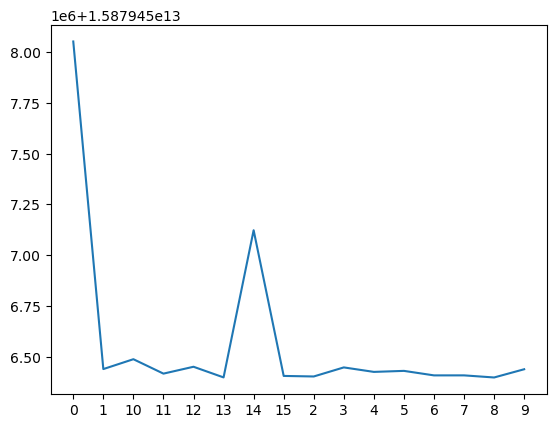

In [46]:
plt.plot(ends)

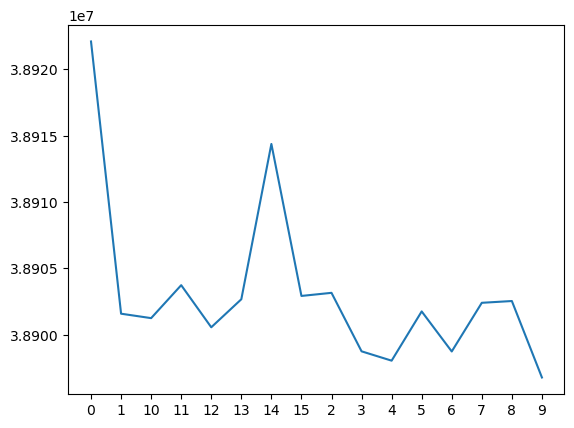

In [48]:
plt.plot(execs)